<h1> Preprocessing </h1>

In [2]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import time
from datetime import date
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from datetime import datetime
import seaborn as sns
from sklearn.metrics import confusion_matrix


#%pip install --upgrade scikit-learn
#%pip install --upgrade imbalanced-learn

from imblearn.over_sampling import RandomOverSampler


In [3]:
train_data = pd.read_csv('data/fraudTrain.csv')
test_data = pd.read_csv('data/fraudTest.csv')

train_data['is_train'] = 1
test_data['is_train'] = 0

In [4]:
split = train_data.size
data = pd.concat([train_data, test_data])

In [5]:
data.tail()
test_data.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,is_train
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0,0


In [6]:
def encode_labels(df, column_name):
    le = preprocessing.LabelEncoder()
    data[column_name] = le.fit_transform(df[column_name])
    return data

def encode_onehot(df, column_name):
    return pd.get_dummies(df, columns=[column_name])

def minmax_scale(df, column_name):
    scaler = preprocessing.MinMacScaler()
    data = scaler.fit_transform(df[column_name])
    return scaler, data

In [7]:
def convert_epoch(df, column_name):
    for name, value in df[column_name].iteritems():
        value = time.strptime(value)
    return df[column_name]
    
def convert_utc(df, column_name):
    for name, value in df[column_name].iteritems():
        value = time.gmtime(value)
    return df[column_name]

In [8]:
def oversampling(df, column_name):
    oversampler = RandomOverSampler(sampling_strategy='auto', random_state=0)
    X = df.drop(column_name, axis=1)
    y = df[column_name]
    X_resampled, y_resampled = oversampler.fit_resample(X, y)
    resampled_df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name=column_name)], axis=1)
    return resampled_df

In [9]:
def calculateAgeWithDateOfBirth(df,column_name):
    #df[column_name]= df[column_name].strftime(df[column_name],'%Y-%m-%d').date()
    df[column_name] = pd.to_datetime(df[column_name], format='%Y-%m-%d')
    #df[column_name] = pd.to_datetime(df[column_name].dt.strftime('%Y-%m-%d'))
    print(type(df[column_name].iloc[1]))
    #current_date= datetime.now()
    current_date= pd.to_datetime(date.today())
    print(type(df[column_name].iloc[1]))
    print(df[column_name].iloc[1])
    
    df['age_in_years'] = (current_date - df[column_name]) // pd.Timedelta(365, 'D')
    df['age_in_years'] = df['age_in_years'].map(lambda x: int(x))
    return df

In [10]:
def makeGenderBinary(df, gender_column):
    df[gender_column]=df[gender_column].map(lambda x: 1 if x == 'M' else 0)
    return df

def convert_to_unixtime(df, datetime_column):

    df['unix_time'] = pd.to_datetime(df[datetime_column]).astype(int) // 10**9
    return df


def replace(x):
    ## the categorisation of jobs was done by hand according to EEO Job Categories
    ## as all the 500+ different jobs were categorised by hand some errors may occur
    ## The idea is to test out if the model could be improved by job categories
    jobstoremember = {'executive': ['Theatre director'], 'mid-level': ['Chief Executive Officer', 'Trading standards officer', 'Chief Strategy Officer', 'Public relations account executive', 'Facilities manager', 'Fisheries officer', 'Call centre manager', 'Heritage manager', 'Travel agency manager', 'Tourist information centre manager', 'Leisure centre manager', 'Production manager', 'Chief Operating Officer', 'Chief Technology Officer', 'Fitness centre manager', 'Health service manager', 'Chief Marketing Officer', 'Farm manager', 'Information systems manager', 'Theme park manager', 'Theatre manager', 'Emergency planning/management officer', 'Quarry manager', 'Records manager', 'Location manager', 'Stage manager', 'Chief of Staff', 'Field trials officer', 'Hotel manager', 'Civil Service administrator', 'Tour manager', 'Armed forces technical officer', 'Warehouse manager'], 'professionals': ['Film/video editor', 'Exhibition designer', 'Naval architect', 'Surveyor, land/geomatics', 'Materials engineer', 'Designer, ceramics/pottery', 'Systems developer', 'IT trainer', 'Financial adviser', 'Environmental consultant', 'Chartered public finance accountant', 'Scientist, audiological', 'Comptroller', 'Sub', 'Podiatrist', 'Agricultural consultant', 'Magazine features editor', 'Historic buildings inspector/conservation officer', 'Librarian, public', 'Building surveyor', 'Musician', 'Water engineer', 'Scientist, research (maths)', 'Mining engineer', 'Barrister', 'Audiological scientist', 'Immunologist', 'Clothing/textile technologist', 'Financial trader', 'Claims inspector/assessor', 'Energy engineer', 'Petroleum engineer', 'Quantity surveyor', 'Make', 'Engineer, automotive', 'Mechanical engineer', 'Geoscientist', 'Counsellor', 'Secondary school teacher', 'Land/geomatics surveyor', 'Early years teacher', 'Sales professional, IT', 'Pensions consultant', 'Psychologist, forensic', 'Psychotherapist, child', 'Librarian, academic', 'Research scientist (physical sciences)', 'Electrical engineer', 'Insurance underwriter', 'Science writer', 'Chartered loss adjuster', 'Drilling engineer', 'Engineer, biomedical', 'Trade mark attorney', 'Special educational needs teacher', 'Scientist, marine', 'Cytogeneticist', 'Chemical engineer', 'Multimedia programmer', 'Accounting technician', 'Counselling psychologist', 'Toxicologist', 'Engineer, production', 'Social researcher', 'Radio producer', 'Fine artist', 'Teacher, special educational needs', 'Race relations officer', 'Engineer, control and instrumentation', 'Surveyor, minerals', 'Educational psychologist', 'Ceramics designer', 'Advertising account planner', 'Town planner', 'Programme researcher, broadcasting/film/video', 'Surgeon', 'Futures trader', 'Television/film/video producer', 'Further education lecturer', 'Scientist, biomedical', 'Designer, industrial/product', 'Applications developer', 'Buyer, industrial', 'Curator', 'Lexicographer', 'Engineering geologist', 'Occupational psychologist', 'Herbalist', 'Pilot, airline', 'Press photographer', 'Archaeologist', 'Editor, commissioning', 'Forensic psychologist', 'Research officer, political party', 'Engineer, electronics', 'Dispensing optician', 'Broadcast presenter', 'Insurance risk surveyor', 'Exercise physiologist', 'Engineer, mining', 'Systems analyst', 'Chiropodist', 'Operations geologist', 'Lecturer, further education', 'Physicist, medical', 'Insurance broker', 'Learning disability nurse', 'Hospital doctor', 'Research officer, trade union', 'Private music teacher', 'Structural engineer', 'Amenity horticulturist', 'Psychologist, counselling', 'Colour technologist', 'Tree surgeon', 'Metallurgist', 'Geologist, engineering', 'Producer, radio', 'Arboriculturist', 'Phytotherapist', 'Education officer, museum', 'Journalist, newspaper', 'Occupational hygienist', 'Site engineer', 'Electronics engineer', 'Regulatory affairs officer', 'Video editor', 'Biomedical scientist', 'Licensed conveyancer', 'Press sub', 'Manufacturing engineer', 'Development worker, international aid', "Barrister's clerk", 'Camera operator', 'Commercial horticulturist', 'Music tutor', 'Health physicist', 'Product/process development scientist', 'Designer, exhibition/display', 'Engineer, land', 'Freight forwarder', 'Lecturer, higher education', 'Commercial/residential surveyor', 'Careers information officer', 'Energy manager', 'Osteopath', 'Wellsite geologist', 'Statistician', 'Market researcher', 'Risk analyst', "Nurse, children's", 'Doctor, general practice', 'Accountant, chartered public finance', 'Health and safety adviser', 'Programmer, multimedia', 'Soil scientist', 'Equality and diversity officer', 'Operational researcher', 'Therapist, sports', 'Building control surveyor', 'Chief Financial Officer', 'Media buyer', 'Database administrator', 'Optician, dispensing', 'Land', 'Mental health nurse', 'Web designer', 'Maintenance engineer', 'Doctor, hospital', 'Teacher, secondary school', 'Engineer, petroleum', 'Product designer', 'Paediatric nurse', 'Armed forces training and education officer', 'Waste management officer', 'Tax adviser', 'Geochemist', 'Investment analyst', 'Patent attorney', 'Therapist, horticultural', 'Surveyor, rural practice', 'Intelligence analyst', 'Teacher, early years/pre', 'Sports development officer', 'Neurosurgeon', 'Transport planner', 'Airline pilot', 'Retail buyer', 'Pension scheme manager', 'Scientist, physiological', 'Psychologist, sport and exercise', 'Landscape architect', 'Telecommunications researcher', 'Industrial/product designer', 'Animal nutritionist', 'Psychiatrist', 'Geologist, wellsite', 'Museum/gallery conservator', 'Clinical research associate', 'Sport and exercise psychologist', 'Editor, film/video', 'Clinical biochemist', 'Nutritional therapist', 'Museum/gallery exhibitions officer', 'Therapist, drama', 'Architect', 'Psychotherapist', 'Retail banker', 'Communications engineer', 'Animal technologist', 'Engineer, drilling', 'Scientist, research (physical sciences)', 'Furniture designer', 'Editor, magazine features', 'Public house manager', 'Cartographer', 'Health promotion specialist', 'Horticulturist, commercial', 'Biomedical engineer', 'Research scientist (life sciences)', 'Investment banker, corporate', 'Herpetologist', 'Public affairs consultant', 'Pharmacist, community', 'Arts development officer', 'Corporate investment banker', 'Civil engineer, contracting', 'Dance movement psychotherapist', 'Engineer, technical sales', 'General practice doctor', 'Health visitor', 'Animator', 'Medical physicist', 'Acupuncturist', 'Engineer, agricultural', 'Planning and development surveyor', 'Embryologist, clinical', 'Oceanographer', 'Pharmacologist', 'Special effects artist', 'Designer, interior/spatial', 'Psychologist, clinical', 'Orthoptist', 'Surveyor, mining', 'Network engineer', 'Psychiatric nurse', 'Training and development officer', 'Community pharmacist', 'Logistics and distribution manager', 'Equities trader', 'Field seismologist', 'Engineer, communications', 'Set designer', 'Interpreter', 'Research scientist (maths)', 'Therapist, music', 'Environmental health practitioner', 'Social research officer, government', 'Physiological scientist', 'Building services engineer', 'Garment/textile technologist', 'Management consultant', 'Engineer, maintenance', 'Aeronautical engineer', 'Commissioning editor', 'Hydrologist', 'Geophysicist/field seismologist', 'Archivist', 'Rural practice surveyor', 'Control and instrumentation engineer', 'Engineer, civil (contracting)', 'Chartered accountant', 'Teacher, primary school', 'Conservation officer, historic buildings', 'Media planner', 'Medical technical officer', 'Plant breeder/geneticist', 'Pharmacist, hospital', 'Scientist, clinical (histocompatibility and immunogenetics)', 'Designer, multimedia', 'Furniture conservator/restorer', 'Engineer, broadcasting (operations)', 'Designer, textile', 'Museum education officer', 'Pathologist', 'Economist', 'Academic librarian', 'Hydrographic surveyor', 'Hospital pharmacist', 'Presenter, broadcasting', 'Biochemist, clinical', 'Environmental education officer', 'Air broker', 'Retail manager', 'Engineer, building services', 'Production assistant, radio', 'Engineer, aeronautical', 'Insurance claims handler', 'Ecologist', 'Civil Service fast streamer', 'Architectural technologist', 'Chartered legal executive (England and Wales)', 'Outdoor activities/education manager', 'Nurse, mental health', 'Loss adjuster, chartered', 'Chemist, analytical', 'Research scientist (medical)', 'Programmer, applications', 'Teacher, English as a foreign language', 'Product manager', 'Clinical psychologist', 'IT consultant', 'Manufacturing systems engineer', 'Scientist, research (medical)', 'Geneticist, molecular', 'Engineer, civil (consulting)', 'Lawyer', 'Estate manager/land agent', 'Engineer, manufacturing', 'Designer, television/film set', 'Accountant, chartered certified', 'TEFL teacher', 'Magazine journalist', 'Horticultural consultant', 'Surveyor, hydrographic', 'Minerals surveyor', 'Associate Professor', 'Oncologist', 'Restaurant manager, fast food', 'Catering manager', 'Local government officer', 'Solicitor, Scotland', 'Broadcast engineer', 'Occupational therapist', 'Textile designer', 'Charity officer', 'Artist', 'Television camera operator', 'Engineer, materials', 'Public relations officer', 'Environmental manager', 'Data scientist', 'Conservator, museum/gallery', 'Teacher, adult education', 'Primary school teacher', 'Education officer, community', 'Nature conservation officer', 'Professor Emeritus', 'Investment banker, operational', 'Water quality scientist', 'Interior and spatial designer', 'Clinical cytogeneticist', 'Purchasing manager', 'Copy', 'Writer', 'Analytical chemist', 'Buyer, retail', 'English as a foreign language teacher', 'Producer, television/film/video', 'Engineer, structural', 'Hydrogeologist', 'Dancer', 'Air traffic controller', 'Legal secretary', 'Personnel officer', 'Engineer, site', 'Solicitor', 'Homeopath', 'Accountant, chartered', 'Industrial buyer', 'Broadcast journalist', 'Forest/woodland manager', 'Information officer', 'Veterinary surgeon', 'Ship broker', 'Contracting civil engineer'], 'technicians': ['Paramedic', 'Technical brewer', 'Radiographer, therapeutic', 'Radiographer, diagnostic', 'Gaffer', 'Scientific laboratory technician', 'Optometrist', 'Diagnostic radiographer', 'Production engineer', 'Teaching laboratory technician'], 'sales': ['Copywriter, advertising', 'Medical sales representative', 'Dealer', 'Retail merchandiser', 'Bookseller', 'Advertising account executive', 'Sales executive', 'Advertising copywriter', 'Visual merchandiser', 'Merchandiser, retail', 'Marketing executive', 'Sales promotion account executive'], 'administrative': ['Television production assistant', 'Radio broadcast assistant', 'Exhibitions officer, museum/gallery', 'Administrator', 'Television floor manager', 'Administrator, local government', 'Administrator, education', 'Human resources officer', 'Administrator, charities/voluntary organisations', 'Charity fundraiser', "Politician's assistant", 'Secretary/administrator', 'Volunteer coordinator', 'Medical secretary', 'Event organiser', 'Sports administrator', 'Company secretary', 'Education administrator', 'Administrator, arts', 'Production assistant, television'], 'craft': ['Designer, jewellery', 'Designer, furniture', 'Community arts worker', 'Glass blower/designer', 'Illustrator', 'Jewellery designer', 'Conservator, furniture'], 'operatives': ['Prison officer', 'Firefighter', 'Armed forces logistics/support/administrative officer', 'Ambulance person'], 'laborers': ['Contractor', 'Mudlogger'], 'service_workers': ['Physiotherapist', 'Therapist, occupational', 'English as a second language teacher', 'Probation officer', 'Senior tax professional/tax inspector', 'Child psychotherapist', 'Development worker, community', 'Warden/ranger', 'Tax inspector', 'Advice worker', 'Tourism officer', 'Police officer', 'Music therapist', 'Therapist, art', 'Horticultural therapist', 'Seismic interpreter', 'Art therapist', 'Immigration officer', 'Community education officer', 'Aid worker', 'Barista', 'Learning mentor', 'Higher education careers adviser', 'Public librarian', 'Cabin crew', 'Art gallery manager', 'Community development worker', 'Air cabin crew', 'Careers adviser']}
    for k in jobstoremember:
        if x in jobstoremember[k]:
            return k
        else:
            return 'other'

def categorise_jobs(data,jobs_column):

    data['job'] = data['job'].map(lambda x: replace(x))
    return data

In [11]:
def splitDateAndTime(data,date_and_time_col):
    data[date_and_time_col] = pd.to_datetime(data[date_and_time_col])
    data['trans_date'] = data[date_and_time_col].dt.strftime('%Y-%m-%d')
    data['trans_date'] = pd.to_datetime(data['trans_date'])
    data['trans_time'] =data[date_and_time_col].dt.time
    return data

In [12]:
def reduceDataWithPCA(data, components):
    from sklearn.decomposition import PCA
    reduced_data = pd.DataFrame(PCA(n_components=components).fit_transform(data))
    reduced_data.columns = ["PC"+str(i+1) for i in range(components)]
    return reduced_data

In [13]:
def plot_ROC(data, model, label_column, plot_title):
    y_val = data[label_column].squeeze()
    X_val = data.drop(columns=[label_column])
    
    probs = model.predict_proba(X_val)
    probs = pd.DataFrame(probs)
    probs = probs[1].squeeze()
    
    cutoffs = pd.DataFrame({'cutoff':probs.unique()})
    cutoffs = cutoffs.sort_values(by='cutoff',ascending=True)
    ##finding true postive rate and false positive rate
    tpr = cutoffs.apply(lambda cut: np.sum(np.logical_and(probs >= cut[0], y_val == 1)) / np.sum(y_val == 1), axis=1)
    fpr = cutoffs.apply(lambda cut: np.sum(np.logical_and(probs >= cut[0], y_val == 0)) / np.sum(y_val == 0), axis=1)

    stats = pd.DataFrame({'cutoff':cutoffs.cutoff, 'tpr':tpr, 'fpr':fpr})
    plt.plot(stats['fpr'],stats['tpr'])
    plt.xlabel('fpr')
    plt.ylabel('tpr')

    plt.title(plot_title)
    plt.show()

def plot_confusion_matrix(y_true_labels, y_predicted_labels):
      
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_true_labels,y_predicted_labels), annot=True, fmt="d", cmap="BuPu")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title("Confusion matrix")
    plt.show()


In [14]:
data.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud', 'is_train'],
      dtype='object')

In [15]:

## Cleaning the data and feature engineering

data = calculateAgeWithDateOfBirth(data,'dob')
data = makeGenderBinary(data, 'gender')
print(data.columns)
## if you want to over sample then don't uncomment these lines, the oversampler can not handle so many col
#data = pd.get_dummies(data, columns=['job'])
#data = encode_onehot(data,'category')
#data = splitDateAndTime(data,'trans_date_trans_time')
data = categorise_jobs(data,'job')

data = data.drop(columns=['Unnamed: 0','first','last','dob','city','street','state','trans_date_trans_time','trans_num','merchant','cc_num'])


## Splitting the data back to train and test after feature engineering and cleanup
train_cleaned = data[data['is_train']==1].drop(columns=['is_train'])
test_cleaned = data[data['is_train']==0].drop(columns=['is_train'])

print(len(train_cleaned), len(test_cleaned))

oversampled_train_labels =train_cleaned['is_fraud']
oversampled_train_data = train_cleaned.drop(columns=['is_fraud'])
X_train, X_test, y_train, y_test = train_test_split(oversampled_train_data,oversampled_train_labels,test_size=0.3,train_size=0.7,random_state=5)

X_train['is_fraud'] = y_train


### Oversampling the data
oversampled_train = oversampling(X_train,'is_fraud')
oversampled_train['is_fraud'].value_counts()
# Onehotting cateogries
oversampled_train = encode_onehot(oversampled_train,'category')
oversampled_train = encode_onehot(oversampled_train,'job')

y_train = oversampled_train['is_fraud']
X_train = oversampled_train.drop(columns=['is_fraud'])


X_test = encode_onehot(X_test,'category')
X_test = encode_onehot(X_test,'job')


<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
1978-06-21 00:00:00
Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud', 'is_train', 'age_in_years'],
      dtype='object')
1296675 555719


<h1> Training models </h1>

<h3> Random Forest Classifier </h3>

In [15]:
## RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier


rf_acc = [[0.863736616065634, 5, 5], [0.863736616065634, 5, 5], [0.8657986663253618, 13, 5], [0.8657986663253618, 13, 5], [0.8663688005978006, 11, 5], [0.8663688005978006, 11, 5], [0.8665911658922666, 3, 5], [0.8665911658922666, 3, 5], [0.8670255539093629, 7, 5], [0.8670255539093629, 7, 5], [0.8672246484171987, 9, 5], [0.8672246484171987, 9, 5], [0.8881321573829156, 3, 10], [0.8881321573829156, 3, 10], [0.8905031919762327, 5, 10], [0.8905031919762327, 5, 10], [0.9116692652378404, 7, 10], [0.9116692652378404, 7, 10], [0.9169297558377354, 9, 10], [0.9169297558377354, 9, 10], [0.9181036377410788, 13, 10], [0.9181036377410788, 13, 10], [0.9212477795791091, 11, 10], [0.9212477795791091, 11, 10], [0.9636109538178311, 5, 15], [0.9636109538178311, 5, 15], [0.9644887796023798, 3, 15], [0.9644887796023798, 3, 15], [0.9714519160907147, 9, 15], [0.9714519160907147, 9, 15], [0.9742547530581692, 7, 15], [0.9742547530581692, 7, 15], [0.9783853176850221, 11, 15], [0.9783853176850221, 11, 15], [0.9796742607000369, 13, 15], [0.9796742607000369, 13, 15], [0.9891842555028947, 3, 20], [0.9891842555028947, 3, 20], [0.9919121088245408, 5, 20], [0.9919121088245408, 5, 20], [0.992779592037254, 7, 20], [0.992779592037254, 7, 20], [0.9937479153253643, 9, 20], [0.9937479153253643, 9, 20], [0.9941163694470085, 11, 20], [0.9941163694470085, 11, 20], [0.994947653658297, 13, 20], [0.994947653658297, 13, 20], [0.9957879876199415, 3, 25], [0.9967886314450383, 5, 25], [0.9969941900602713, 7, 25], [0.9972307763910113, 11, 25], [0.9972915390005456, 9, 25], [0.9973988431833402, 13, 25], [0.9975914735837788, 3, 30], [0.9980995524252038, 5, 30], [0.9982184920013135, 7, 30], [0.9982714976819711, 9, 30], [0.9983206248981903, 11, 30], [0.9984499070461357, 13, 30], [0.9988519745262455, 3, 35], [0.9989140299572593, 5, 35], [0.9989851351386293, 7, 35], [0.9990174556756156, 11, 35], [0.999058825962958, 9, 35], [0.9991066603576978, 13, 35], [0.9991312239658074, 3, 40], [0.999184229646465, 3, 45], [0.9992359425056432, 5, 40], [0.999255334827835, 5, 45], [0.9992876553648213, 7, 40], [0.999309633329972, 11, 40], [0.9993160974373693, 9, 40], [0.9993316112951227, 13, 40], [0.9993406610454789, 7, 45], [0.9993729815824652, 13, 45], [0.9993833241543009, 11, 45], [0.9993910810831775, 9, 45]]
## The loop takes long time to run, the results are appended into rf_acc, just trust them or wait for an hour
#for i in range(3,15,2):
#    for j in range(5,25,5):
#        rf = RandomForestClassifier(n_estimators=i, max_depth=j, random_state=0).fit(X_train, y_train)
#        acc = accuracy_score(rf.predict(X_test),y_test)
#        rf_acc.append([acc,i,j])
        
rf_acc = sorted(rf_acc,key=lambda x: x[0],reverse=True)
print(rf_acc[0])
print(rf_acc[int(len(rf_acc)/4)])
print(rf_acc[int(len(rf_acc)/2)])
print(rf_acc[-(int(len(rf_acc)/4))])
print(rf_acc[-1])

[0.9993910810831775, 9, 45]
[0.9983206248981903, 11, 30]
[0.9919121088245408, 5, 20]
[0.9169297558377354, 9, 10]
[0.863736616065634, 5, 5]


<p> After finding the some of the Random Forest Classifiers that have the best accuracy on test portion of the train_test_split data we want to validate it on the separate data file. As we have only ca 2000 fraud cases in the testing dataset we want to evaluate the model based on the confusion matrix. We want to find the model that is able to catch as many frauds as possible with as low of a II errors as possible. To take into consideration the overfitting of the model, we will evaluate the best model by accuracy, a model from the middle, the model with the worst accuracy, a model in the upper 0.75quantile and a model in the lower 0.25 quantile.

In [16]:
rf_1 = RandomForestClassifier(n_estimators=9, max_depth=45, random_state=0).fit(X_train, y_train)
rf_2 = RandomForestClassifier(n_estimators=11, max_depth=30, random_state=0).fit(X_train, y_train)
rf_3 = RandomForestClassifier(n_estimators=5, max_depth=20, random_state=0).fit(X_train, y_train)
rf_4 = RandomForestClassifier(n_estimators=9, max_depth=10, random_state=0).fit(X_train, y_train)
rf_5 = RandomForestClassifier(n_estimators=5, max_depth=5, random_state=0).fit(X_train, y_train)



In [19]:
### ROC curve of rf_1

##One hot encoding the test dataset after feature engineering and cleanup
test_cleaned_onehot = encode_onehot(test_cleaned,'category')
test_cleaned_onehot = encode_onehot(test_cleaned_onehot,'job')

## X and y validation dataframes for predicting probability
y_val = test_cleaned_onehot['is_fraud'].squeeze()
X_val = test_cleaned_onehot.drop(columns=['is_fraud'])# features


print("Accuracy of rf_1 model on validation data from test_train_split: ",accuracy_score(rf_1.predict(X_test),y_test))
print("Accuracy of rf_1 model on test data from the separate file: ",accuracy_score(rf_1.predict(X_val),y_val))
plot_ROC(test_cleaned_onehot,rf_1,'is_fraud','Random Forest Classifier n_esitmators=9, max_depth=45')


y_true = y_val
y_pred = rf_1.predict(X_test)
y_pred_testfile = rf_1.predict(X_val)
print("Confusion matrix for the test data from train test split")
plot_confusion_matrix(y_test,y_pred)
print("Confusion matrix for the separate test file")
plot_confusion_matrix(y_true,y_pred_testfile)

print("Accuracy of rf_2 model on validation data from test_train_split: ",accuracy_score(rf_2.predict(X_test),y_test))
print("Accuracy of rf_2 model on test data from the separate file: ",accuracy_score(rf_2.predict(X_val),y_val))
plot_ROC(test_cleaned_onehot,rf_1,'is_fraud','Random Forest Classifier n_esitmators=11, max_depth=30')
y_true = y_val
y_pred = rf_2.predict(X_test)
y_pred_testfile = rf_2.predict(X_val)
print("Confusion matrix for the test data from train test split")
plot_confusion_matrix(y_test,y_pred)
print("Confusion matrix for the separate test file")
plot_confusion_matrix(y_true,y_pred_testfile)

print("Accuracy of rf_3 model on validation data from test_train_split: ",accuracy_score(rf_3.predict(X_test),y_test))
print("Accuracy of rf_3 model on test data from the separate file: ",accuracy_score(rf_3.predict(X_val),y_val))
plot_ROC(test_cleaned_onehot,rf_1,'is_fraud','Random Forest Classifier n_esitmators=5, max_depth=20')
y_true = y_val
y_pred = rf_3.predict(X_test)
y_pred_testfile = rf_3.predict(X_val)

print("Confusion matrix for the test data from train test split")
plot_confusion_matrix(y_test,y_pred)
print("Confusion matrix for the separate test file")
plot_confusion_matrix(y_true,y_pred_testfile)

print("Accuracy of rf_4 model on validation data from test_train_split: ",accuracy_score(rf_4.predict(X_test),y_test))
print("Accuracy of rf_4 model on test data from the separate file: ",accuracy_score(rf_4.predict(X_val),y_val))
plot_ROC(test_cleaned_onehot,rf_1,'is_fraud','Random Forest Classifier n_esitmators=9, max_depth=10')
y_true = y_val
y_pred = rf_4.predict(X_test)
y_pred_testfile = rf_4.predict(X_val)

print("Confusion matrix for the test data from train test split")
plot_confusion_matrix(y_test,y_pred)
print("Confusion matrix for the separate test file")
plot_confusion_matrix(y_true,y_pred_testfile)

print("Accuracy of rf_5 model on validation data from test_train_split: ",accuracy_score(rf_5.predict(X_test),y_test))
print("Accuracy of rf_5 model on test data from the separate file: ",accuracy_score(rf_5.predict(X_val),y_val))
plot_ROC(test_cleaned_onehot,rf_1,'is_fraud','Random Forest Classifier n_esitmators=5, max_depth=5')
y_true = y_val
y_pred = rf_5.predict(X_test)
y_pred_testfile = rf_5.predict(X_val)

print("Confusion matrix for the test data from train test split")
plot_confusion_matrix(y_test,y_pred)
print("Confusion matrix for the separate test file")
plot_confusion_matrix(y_true,y_pred_testfile)



NameError: name 'rf_1' is not defined

<p> By using a Random Forest Classifier it seems that the modes with better accuracy tend to have a greater type 2 error rate than models with lesser accuracy on the validation data. It also occurs that models with a smaller depth and a smaller n_estimators tend to classify fraudulet transactions better. The most promising model out of the five tested ones seems to be the classifier with n_estimators=9 and max_depth=10.  </p>

<h3> Descision Tree Classifier</h3>

In [ ]:
from sklearn import tree

decision_tree = tree.DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
tree.plot_tree(decision_tree)

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn import tree
import time

param_grid = {
    'max_depth': np.arange(3, 15, 2),
    'min_samples_split': np.arange(10, 500, 20) 
}

start = time.time()

tree_clf = tree.DecisionTreeClassifier()
grid_search = GridSearchCV(tree_clf, param_grid)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

end = time.time()

print(f"Best Parameters: {best_params}")
execution_time = (end - start) / 60 #find out how long this takes in minutes
print(f'Execution time: {execution_time}')

Best Parameters: {'max_depth': 13, 'min_samples_split': 70}
Execution time: 79.29532189766566


[Text(0.7942122506366723, 0.9642857142857143, 'x[0] <= 235.655\ngini = 0.5\nsamples = 1804936\nvalue = [902468, 902468]'),
 Text(0.6236537033106961, 0.8928571428571429, 'x[0] <= 24.255\ngini = 0.318\nsamples = 1093837\nvalue = [876965, 216872]'),
 Text(0.4871206494057725, 0.8214285714285714, 'x[12] <= 0.5\ngini = 0.463\nsamples = 502393\nvalue = [319348, 183045]'),
 Text(0.4062234719864177, 0.75, 'x[0] <= 16.985\ngini = 0.382\nsamples = 430007\nvalue = [319286, 110721]'),
 Text(0.3205114601018676, 0.6785714285714286, 'x[13] <= 0.5\ngini = 0.268\nsamples = 332176\nvalue = [279193, 52983]'),
 Text(0.2352504244482173, 0.6071428571428571, 'x[19] <= 0.5\ngini = 0.211\nsamples = 316236\nvalue = [278321, 37915]'),
 Text(0.1322156196943973, 0.5357142857142857, 'x[23] <= 0.5\ngini = 0.134\nsamples = 268801\nvalue = [249400, 19401]'),
 Text(0.05432937181663837, 0.4642857142857143, 'x[17] <= 0.5\ngini = 0.056\nsamples = 232008\nvalue = [225271, 6737]'),
 Text(0.022071307300509338, 0.3928571428571

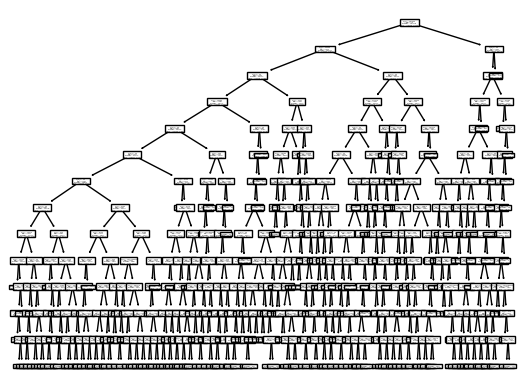

In [17]:
from sklearn import tree

tree2 = tree.DecisionTreeClassifier(max_depth=13, min_samples_split=70)
tree2.fit(X_train, y_train)
tree.plot_tree(tree2)

In [ ]:
y_true = y_val
y_pred = tree2.predict(X_test)
y_pred_testfile = tree2.predict(X_val)
print("Confusion matrix for the test data from train test split")
plot_confusion_matrix(y_test,y_pred)
print("Confusion matrix for the separate test file")
plot_confusion_matrix(y_true,y_pred_testfile)

In [ ]:
print("Accuracy of dt_1 model on test data from test_train_split: ",accuracy_score(decision_tree.predict(X_test),y_test))
print("Accuracy of dt_1 model on validation data from the separate file: ",accuracy_score(decision_tree.predict(X_val),y_val))

y_true = y_val
y_pred = decision_tree.predict(X_val)


print(test_data['is_fraud'].value_counts())
print(confusion_matrix(y_true,y_pred))

In [ ]:
#gpt
import matplotlib.pyplot as plt

# Plot the decision tree
plt.figure(figsize=(20, 10))  # Adjust the figure size as needed
plot_tree(decision_tree, filled=True, rounded=True)
plt.savefig('decision_tree.png')
plt.show()